[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/khetansarvesh/MSML_602/blob/main/image_classification_DL.ipynb)

# <h1> <b> <center> Image Classification Using Feed Forwared Neural Networks / Convolution Neural Networks / Vision Transformers </center> </b> </h1>


Collaborators:
- Sarvesh Khetan
- Siri Lakshamana Reddy Yeresimi
- Umesh Adari

# <h1> <b> <center> Introduction </center> </b> </h1>

<div> <center>
In the ever changing world of online shopping, product categorization accuracy is becoming more and more crucial. Customers will be more satisfied and have greater conversion rates if they can quickly search for and locate the products they want thanks to an automatic tagging system that works well. But one of the biggest problems in creating such systems is the noisy data present, where objects maybe incorrectly identified for a number of reasons, including mislabeling or unclear labeling made during data collection or because of a bad model. Hence our aim is to build such a model which is robust to noisy data. Researcher have found multiple ways to do so using Deep Learning. We want to see how these different Deep Learning models perform on this type of dataset. Answering these questions are important because it will help us understand how these models tend to reason and the mathematics behind these models. Having a good understanding will lead to further research in this area to solve issues faced by the already existing model architectures!!
</center> </div>




# <h1> <b> <center> Installing Relevant Libraries </center> </b> </h1>

In [ ]:
!pip install "cleanvision[huggingface]"
!pip install pyod

# <h1> <b> <center> Relevant Imports </center> </b> </h1>

In [ ]:
# Import PyTorch
import torch
from torch import nn


from einops import rearrange

# import pandas as pd
import os
import pandas as pd
import numpy as np
from datasets import load_dataset, concatenate_datasets
from cleanvision import Imagelab
from PIL import Image
import requests
import cv2
import imagehash

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, TensorDataset

# Import matplotlib for visualization
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

- Since we will be training deep learning models which are compute heavy, we will use TPUs (T4 available on google colab) instead of CPUs.


- TPUs are designed to perform tensor operations much faster compared to CPUs and GPUs and hence using TPUs help us to train model more faster compared to CPUs and GPUs

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# <h1> <b> <center> Data curation </center> </b> </h1>

Earlier we planned to use [Clothing1M dataset](https://paperswithcode.com/dataset/clothing1m) but the authors of this paper have not reverted back with the dataset drive link and hence we pivoted to using the fashionMNIST dataset. Here are some key things to know about [fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) :

- It consists of 70,000 grayscale images of fashion products from 10 categories.

- The dataset is split into 60,000 training images and 10,000 test images.

- Each image is 28x28 pixels in size.

- The images are in grayscale, with pixel values ranging from 0 to 255.

- There are 10 classes of fashion items, including T-shirts, trousers, dresses, and more.

- It was created by Zalando Research as a more challenging alternative to the original MNIST dataset.


- Fashion MNIST shares the same image size, data format, and structure of training and testing splits with the original MNIST dataset.


### Downloading Dataset

In [ ]:
dataset_dict = load_dataset("zalando-datasets/fashion_mnist")

# train dataset
train_data = dataset_dict['train']
train_images = np.array(train_data['image'])
train_labels = np.array(train_data['label'])

# test dataset
test_data = dataset_dict['test']
test_images = np.array(test_data['image'])
test_labels = np.array(test_data['label'])

### Visualizing Dataset

In [ ]:
label_dic = {
    0 : 'T-shirt/top',
    1 : 'Trouser',
    2 : 'Pullover',
    3 : 'Dress',
    4 : 'Coat',
    5 : 'Sandal',
    6 : 'shirt',
    7 : 'Sneaker',
    8 : 'Bag',
    9 : 'Ankle boot'
}

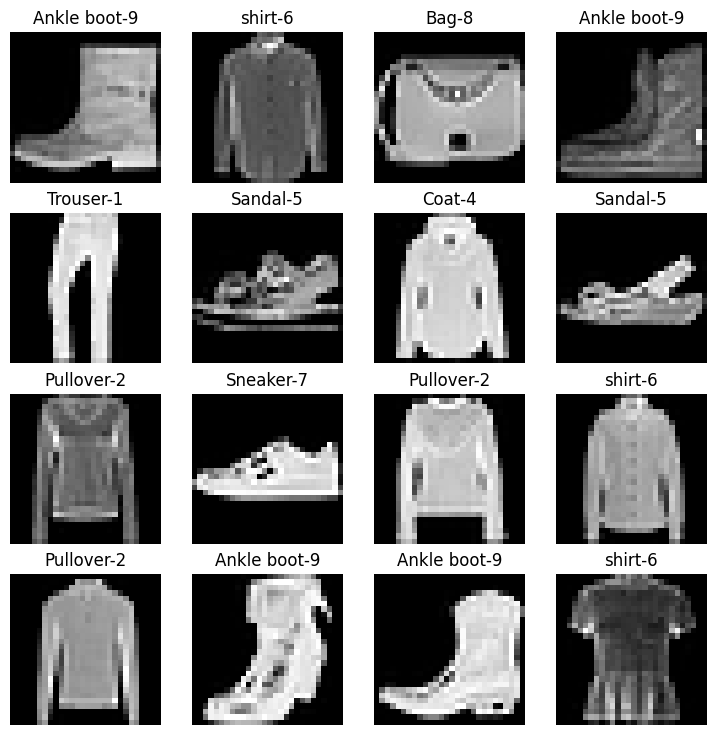

In [ ]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))

for i in range(1, 4 * 4 + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img = train_images[random_idx]
    label = train_labels[random_idx]
    fig.add_subplot(4, 4, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f'{label_dic[label]}-{label}')
    plt.axis(False);

# <h1> <b> <center> Data Cleaning </center> </b> </h1>
Before performing any analysis on our dataset we need to make sure that our data is good else the model built on this data would not be a good model. Hence here in this section we will try to remove all the irregularities present in the dataset. Some of the irregularities can be
- duplicate images
- images with low information
- blurry images
- dark images
- light images
- ...

In [ ]:
imagelab = Imagelab(hf_dataset=train_data, image_key="image")
imagelab.find_issues()

Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

Issue checks completed. 70003 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().


In [ ]:
imagelab.issue_summary

,issue_type,num_images
0,grayscale,60000
1,low_information,9266
2,near_duplicates,721
3,dark,16
4,light,0
5,blurry,0
6,odd_aspect_ratio,0
7,odd_size,0
8,exact_duplicates,0


Hence from above dataframe we can see what all issues are present in the dataset and respective no of images which have issue!! But is does not tell us exactly which image has which issue, and hence we can use the imagelab.issues api to get this information as shown below

In [ ]:
issue_df = imagelab.issues
issue_df

,odd_size_score,is_odd_size_issue,odd_aspect_ratio_score,is_odd_aspect_ratio_issue,low_information_score,is_low_information_issue,light_score,is_light_issue,grayscale_score,is_grayscale_issue,dark_score,is_dark_issue,blurry_score,is_blurry_issue,exact_duplicates_score,is_exact_duplicates_issue,near_duplicates_score,is_near_duplicates_issue
0,1.0,False,1.0,False,0.471182,False,1.0,False,0,True,0.964706,False,0.782126,False,1.0,False,1.0,False
1,1.0,False,1.0,False,0.488036,False,1.0,False,0,True,0.992824,False,0.609102,False,1.0,False,1.0,False
2,1.0,False,1.0,False,0.307095,False,1.0,False,0,True,0.835373,False,0.759629,False,1.0,False,1.0,False
3,1.0,False,1.0,False,0.412742,False,1.0,False,0,True,0.762118,False,0.793485,False,1.0,False,1.0,False
4,1.0,False,1.0,False,0.326907,False,1.0,False,0,True,1.000000,False,0.830525,False,1.0,False,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,1.0,False,1.0,False,0.273430,True,1.0,False,0,True,0.868078,False,0.830474,False,1.0,False,1.0,False
59996,1.0,False,1.0,False,0.277721,True,1.0,False,0,True,0.996078,False,0.867324,False,1.0,False,1.0,False
59997,1.0,False,1.0,False,0.348192,False,1.0,False,0,True,1.000000,False,0.852952,False,1.0,False,1.0,False
59998,1.0,False,1.0,False,0.436144,False,1.0,False,0,True,0.620275,False,0.507929,False,1.0,False,1.0,False


## Check for Images with Low Information in dataset
There are many ways to check if the image contains low information or not eg using entropy value or using variance across different axes of the image.

In [ ]:
images_with_low_information = issue_df[issue_df['is_low_information_issue'] == True].reset_index()[['index','low_information_score']]
images_with_low_information

,index,low_information_score
0,8,0.292135
1,13,0.296907
2,14,0.244999
3,30,0.169186
4,38,0.294015
...,...,...
9261,59951,0.268701
9262,59991,0.267101
9263,59995,0.273430
9264,59996,0.277721


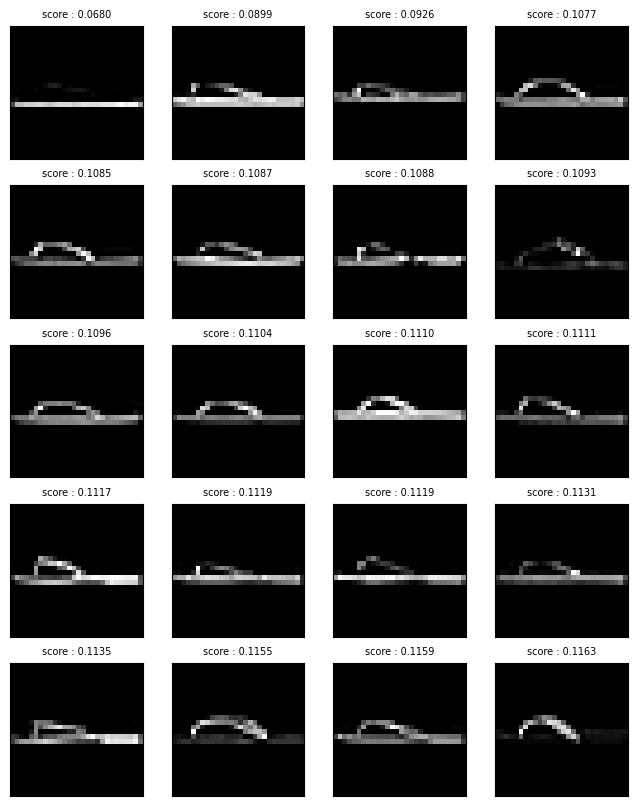

In [ ]:
imagelab.visualize(issue_types=["low_information"], num_images=20)

In [ ]:
# storing all the image indexes which shows low information
img_index_with_low_information = images_with_low_information['index']

## Check for Blurry Images in dataset
There are many ways to check blurriness in an image like laplacian and fourier transform.

Imagelab library suggests that are are no blurry images in our dataset, let's check that manually too by implementing our own version to check for blurry images.

In [ ]:
is_blurry_image = [cv2.Laplacian(image, cv2.CV_64F).var()<1000 for image in train_images]

In [ ]:
for i in is_blurry_image:
  if i == True:
    print(i)

Hence this shows that there are no blurry images in our dataset

## Check for Light / Dark Images in dataset
Here we first identify if there are too dark or too light images in our dataset

In [ ]:
dark_images = issue_df[issue_df['is_dark_issue'] == True].reset_index()[['index','dark_score']]

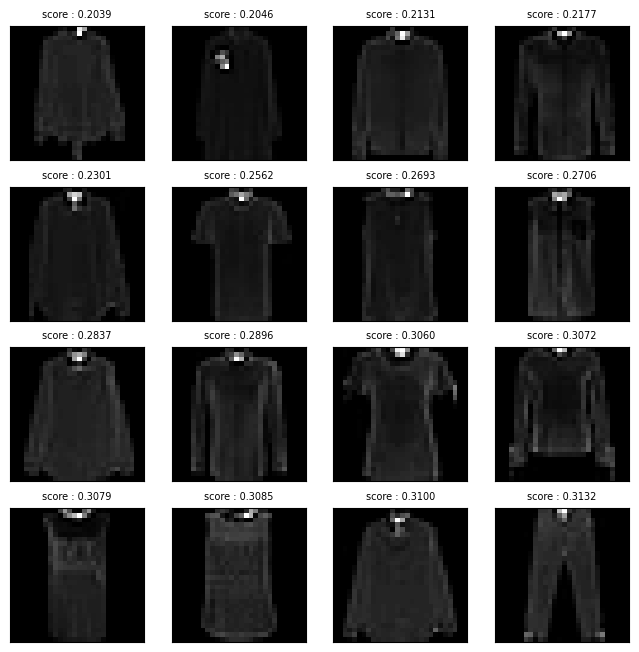

In [ ]:
imagelab.visualize(issue_types=["dark"], num_images=20)

In [ ]:
# storing all the image indexes which shows light dark issue
dark_img_index = dark_images['index']

## Check for duplicate Images
To manually implement this you will have to convert the images into embeddings and then using a similarity measure you can check if the images are similiar or not. If the similarity is too high means they are near duplicates.

In [ ]:
duplicate_images = issue_df[issue_df['is_near_duplicates_issue'] == True].reset_index()[['index','near_duplicates_score']]

Set: 0


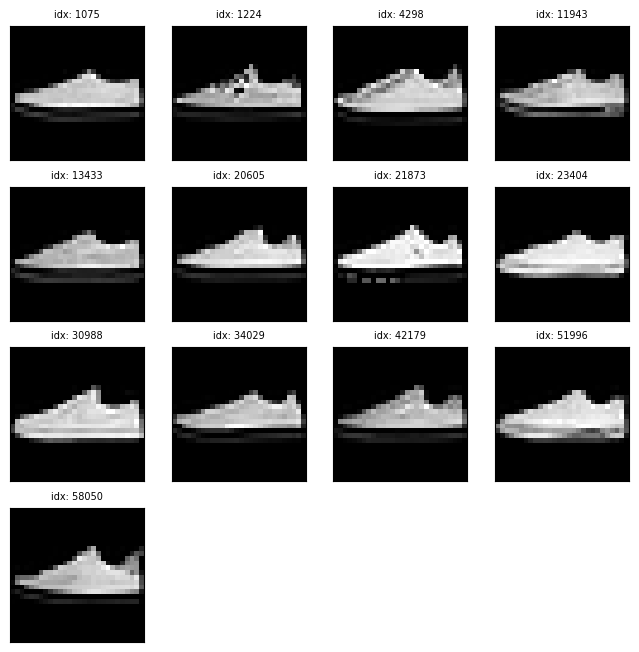

Set: 1


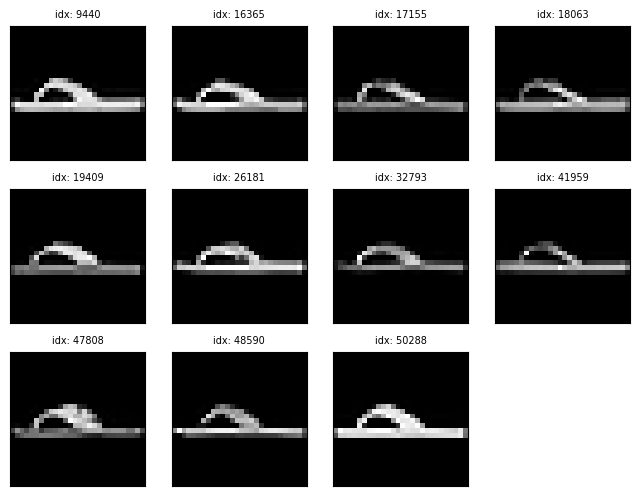

Set: 2


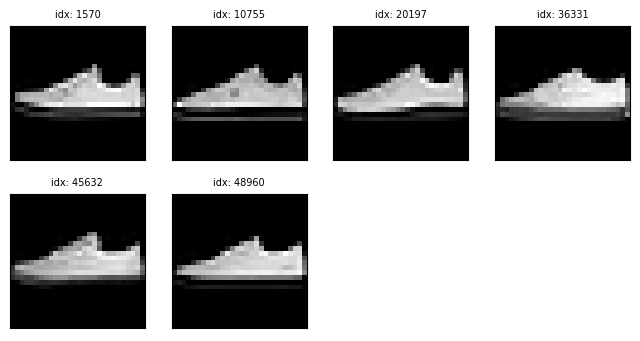

Set: 3


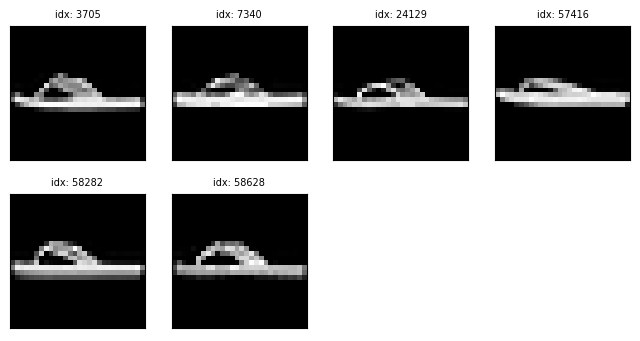

Set: 4


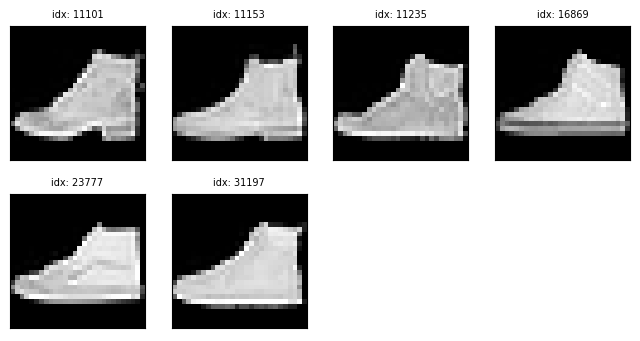

In [ ]:
# visualizing 5 near duplicate sets
imagelab.visualize(issue_types=["near_duplicates"], num_images=5)

In [ ]:
print(f'Total #Duplicate Sets Found : {len(imagelab.info["near_duplicates"]["sets"])}')

Total #Duplicate Sets Found : 314


In [ ]:
# storing all the image indexes which are duplicates
duplicate_images_index = []
for i in imagelab.info["near_duplicates"]["sets"]:
  for j,counter in zip(i,range(0,len(i))):
    if counter == 0:
      continue
    else:
      duplicate_images_index.append(j)

## Removing Issue Based Images from the Dataset

In [ ]:
# appending all the images with different types of issues
to_remove = list(set(list(img_index_with_low_information) + list(dark_img_index) + list(duplicate_images_index)))

In [ ]:
print(f'Number of bad images found : {len(to_remove)}')

Number of bad images found : 9497


## Updated Training Dataset

In [ ]:
# new image list => removing images which has issues from the original image list
reduced_train_images = []
reduced_train_labels = []

for counter, im, label in zip(range(len(train_images)), train_images, train_labels):

    if counter in to_remove:
        continue

    else:
        reduced_train_images.append(im)
        reduced_train_labels.append(label)

## Normalizing Data
It is important to normalize image data to improve the performance of the downstream modelling task. Here we convert the image pixels from 0-255 to 0-1 values. Because of this conversion the model trains faster as the gradient descent converges quickly (comparatively)

In [ ]:
def normalize_image_np(image):
    norm_img = (image - np.min(image)) / (np.max(image) - np.min(image))
    return norm_img

In [ ]:
train_images = [normalize_image_np(image) for image in reduced_train_images]
test_images = [normalize_image_np(image) for image in test_images]

# <h1> <b> <center> Modelling and Training using Feed Forward Neural Networks </center> </b> </h1>

Here we will try to model this problem using a simple FFNN i.e. we will pass the image data to a Feed Forward Neural Network. One of the easiest ways to do so is to just flatten the image and treat it like a (image_width * image_height * image_channel) dimension datapoint and hence feed it to a NN with input layer having (image_width * image_height * image_channel) neurons. We have explained this visually here in our [medium article](https://levelup.gitconnected.com/modelling-based-methods-for-image-representation-learning-48cd5f56ad0d#0e80).


## Create Embeddings using Eigen Value Decomposition (PCA)
To improve the performance of this system instead of directly feeding the model with the flattened image we will perform dimensionality reduction on this flattened image. This will help in two ways :
- It will help increase the accuracy of the model since we are feeding matured features to the model instead of raw features
- It will help save some compute cost since now we will need to develop a slightly smaller model compared to previous model where we feeded the entire flattened image to the FFNN Model.

We can use several methods to perform dimensionality reduction but we will be using Principal Component Analysis (PCA). To understand the working of PCA you can refer to this [medium article](https://pub.towardsai.net/principle-component-analysis-pca-mathematics-9cfba3c66b45)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# flattening the train images
X_train = np.array(train_images).reshape(50503, 28 * 28)
Y_train = reduced_train_labels

In [ ]:
# flattening the test images
X_test = np.array(test_images).reshape(10000, 28 * 28)
Y_test = test_labels

In [ ]:
# fitting PCA
pca = PCA(n_components = None)
X_new = pca.fit_transform(X_train)

In [ ]:
# Calculating new no of features such that 85% of the information in the dataset is retained
threshold = 0.85
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= threshold) + 1
print(n_components)

46


Hence we can say that we have extracted 195 features out of 28*28 features which retains 95% of the information in the dataset

In [ ]:
# fitting PCA again to get those 195 features
pca = PCA(n_components = n_components)
X_train = pca.fit_transform(X_train)
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,-2.208439,6.145195,-4.134287,0.815395,-0.687318,-1.570434,0.025577,1.012756,0.656292,0.215190,...,0.116200,-0.037935,0.072052,0.016992,0.112778,-0.542487,-0.337188,0.450976,0.025373,0.296288
1,4.859011,-2.047888,-2.156956,0.937111,1.968101,3.931461,-1.683637,-1.101950,0.847573,0.097526,...,-0.116398,0.046202,-0.093764,-0.378994,-0.125859,0.199978,-0.132966,-0.066531,0.016735,-0.186447
2,-3.259009,-4.971990,0.595483,0.373040,0.331977,-0.572131,0.530642,0.072513,0.473651,0.246415,...,0.569309,0.294184,-0.353557,0.188509,-0.246925,-0.201548,-0.331330,-0.066482,-0.090224,-0.187455
3,-0.318511,-4.400119,0.550357,1.095033,0.448122,0.335890,-0.305261,0.025219,0.442680,2.009224,...,-0.279800,-0.414233,-0.084571,0.215792,-0.283175,-0.194854,-0.277283,0.397176,0.253820,0.061514
4,2.592005,-4.669180,-3.178935,-1.135868,-1.698617,-0.518074,1.712628,0.473259,1.015055,0.100512,...,0.431989,0.360399,-0.109942,0.155513,0.031614,0.103302,0.046732,-0.264479,0.045781,-0.385623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50498,-6.586370,0.447454,0.052691,-1.602056,0.221330,0.116083,-0.715780,-1.499584,0.016413,-0.119027,...,0.129045,-0.509618,0.778261,-0.463077,0.011430,-0.376195,-0.256612,0.082516,0.276708,0.277510
50499,0.208006,-1.967429,1.863021,0.868961,-1.563636,-0.547244,-1.121710,0.551923,-0.928694,0.165407,...,0.304787,0.591432,-0.325304,0.093853,0.054438,0.087310,-0.085039,-0.431965,0.213420,0.327283
50500,0.801886,7.768272,-1.141110,-2.367468,-0.231923,1.700106,2.303612,3.891102,-0.974718,0.215461,...,0.189357,0.258287,0.074399,-0.031048,0.087975,0.235431,0.408168,0.520098,-0.558213,-0.244509
50501,2.882347,-4.559922,-2.236861,-1.986208,-0.471375,-1.050567,0.364239,0.116209,-0.994251,-1.611482,...,-0.169781,-0.100659,0.523275,-0.128593,1.071321,0.007489,0.927778,-0.118338,-0.018247,0.304502


In [ ]:
X_test = pca.fit_transform(X_test)

## Visualization
Now let's try reducing the dimension to 2 to understand how the data is distributed in 2d space, it will give us a rough idea of how non linear function do we need to learn and hence it will give us an estimate of complexity of FFNN that we need to design...

In [ ]:
# creating 2d features to plot a diagram
pca = PCA(n_components = 2)
X_new_temp = pca.fit_transform(X_train)

In [ ]:
dataset = pd.DataFrame(X_new_temp, columns=['Feature 1', 'Feature 2'])
dataset['Label'] = reduced_train_labels

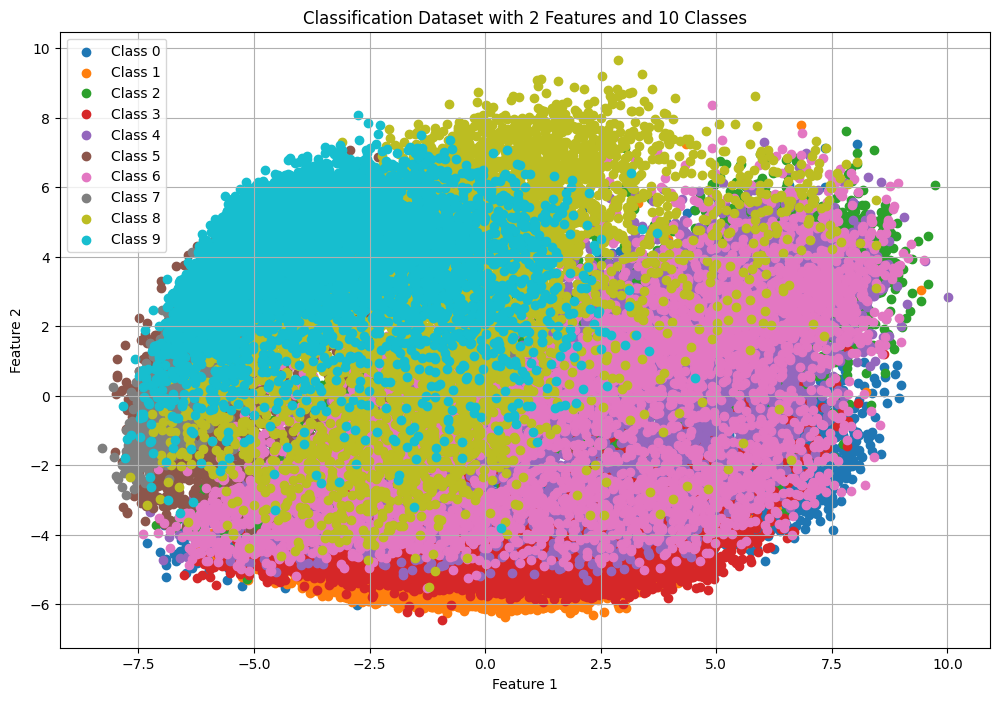

In [ ]:
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10(np.linspace(0, 1, 10))  # Use a colormap to get distinct colors for each class

for class_value in range(10):
    subset = dataset[dataset['Label'] == class_value]
    plt.scatter(subset['Feature 1'], subset['Feature 2'], label=f'Class {class_value}', color=colors[class_value])

plt.title('Classification Dataset with 2 Features and 10 Classes')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

## Independent Feature Correlation Analysis
Using this we can decide which feature to drop. If two features are highly correlated then we can drop one of them since they are almost similar features

In [ ]:
numerical_features = pd.DataFrame(X_train).select_dtypes(include=np.number)

# Calculate the correlation matrix
correlation_matrix = numerical_features.corr()

# Mask the upper triangle for better readability
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create the heatmap
plt.figure(figsize=(100, 100))
import seaborn as sns
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features in Boston Housing Data', fontsize=16)
plt.show()

Hence we can conclude that almost all features are important and non can be dropped since non of them are in highly correlated as seen by the figure!!

## Outlier Handling
Removing outlier datapoints can be helpful for the model so that it learns a general pattern of our dataset and hence this step also turns out to be critical while designing a robust modelling system. Here we will be using Isolation Forest Algorithm to determine Outliers in our Dataset!!

In [ ]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(random_state=42)
clf.fit(X_train)
outlier_pred = clf.predict(X_train)

2D visualization after removing outliers


In [ ]:
dataset['outlier'] = outlier_pred # adding a outlier col in the dataset
dataset['Label'] = dataset['Label'].where(dataset['outlier'] != -1, 10) # creating outlier points as class 10

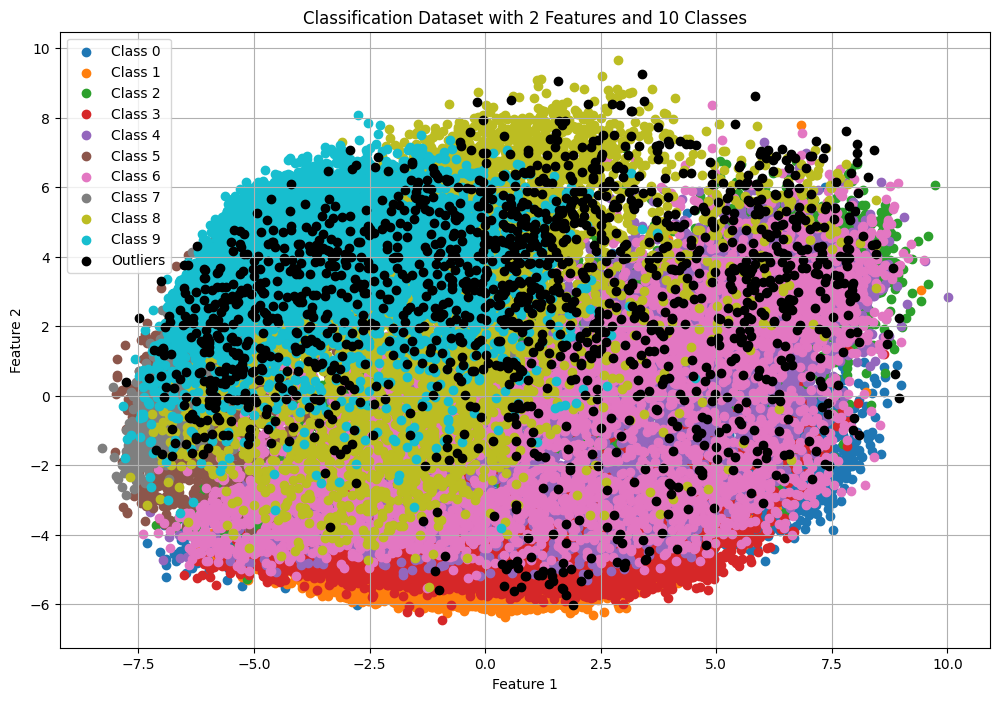

In [ ]:
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10(np.linspace(0, 1, 11))  # Use a colormap to get distinct colors for each class

for class_value in range(11):
    subset = dataset[dataset['Label'] == class_value]
    if class_value == 10:
      plt.scatter(subset['Feature 1'], subset['Feature 2'], label=f'Outliers', color='black')
    else:
      plt.scatter(subset['Feature 1'], subset['Feature 2'], label=f'Class {class_value}', color=colors[class_value])

plt.title('Classification Dataset with 2 Features and 10 Classes')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

Note : In 2d plot they might not look at outliers since we have reduced the dimensions but in the original dimensions they are outliers based on isolation forest method

Dataset after removal of outliers

In [ ]:
train_df = pd.DataFrame(X_train)
train_df['Label'] = Y_train
train_df['outlier'] = outlier_pred

In [ ]:
train_df = train_df[train_df['outlier'] != -1]

In [ ]:
X_train = np.array(train_df.drop(['Label', 'outlier'], axis=1))
Y_train = np.array(train_df['Label'])

## Creating Dataloaders
Dataloaders are an important concept while training a Deep Learning Model. It is just a way which makes it easy for the pytorch library to feed the data to the model

In [ ]:
x_train = np.array(X_train)
y_train = np.array(Y_train)
x_test = np.array(X_test)
y_test = np.array(Y_test)

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

In [ ]:
reduced_train_images_tensor = torch.stack([transform(Image.fromarray(img)) for img in x_train])
reduced_train_labels_tensor = torch.tensor(np.array(y_train), dtype=torch.long)
train_dataset = TensorDataset(reduced_train_images_tensor, reduced_train_labels_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
train_features_batch, train_labels_batch = next(iter(train_dataloader))

print(f"Features Batch Size {train_features_batch.shape}")
print(f"Labels Batch Size {train_labels_batch.shape}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of 32")

Features Batch Size torch.Size([32, 1, 46, 1])
Labels Batch Size torch.Size([32])
Length of train dataloader: 1529 batches of 32


In [ ]:
reduced_test_images_tensor = torch.stack([transform(Image.fromarray(img)) for img in x_test])
reduced_test_labels_tensor = torch.tensor(np.array(y_test), dtype=torch.long)
test_dataset = TensorDataset(reduced_test_images_tensor, reduced_test_labels_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_features_batch, test_labels_batch = next(iter(test_dataloader))

print(f"Features Batch Size {test_features_batch.shape}")
print(f"Labels Batch Size {test_labels_batch.shape}")
print(f"Length of train dataloader: {len(test_dataloader)} batches of 32")

Features Batch Size torch.Size([32, 1, 46, 1])
Labels Batch Size torch.Size([32])
Length of train dataloader: 313 batches of 32


## Model Architecture
We will be creating following model as shown in the image below

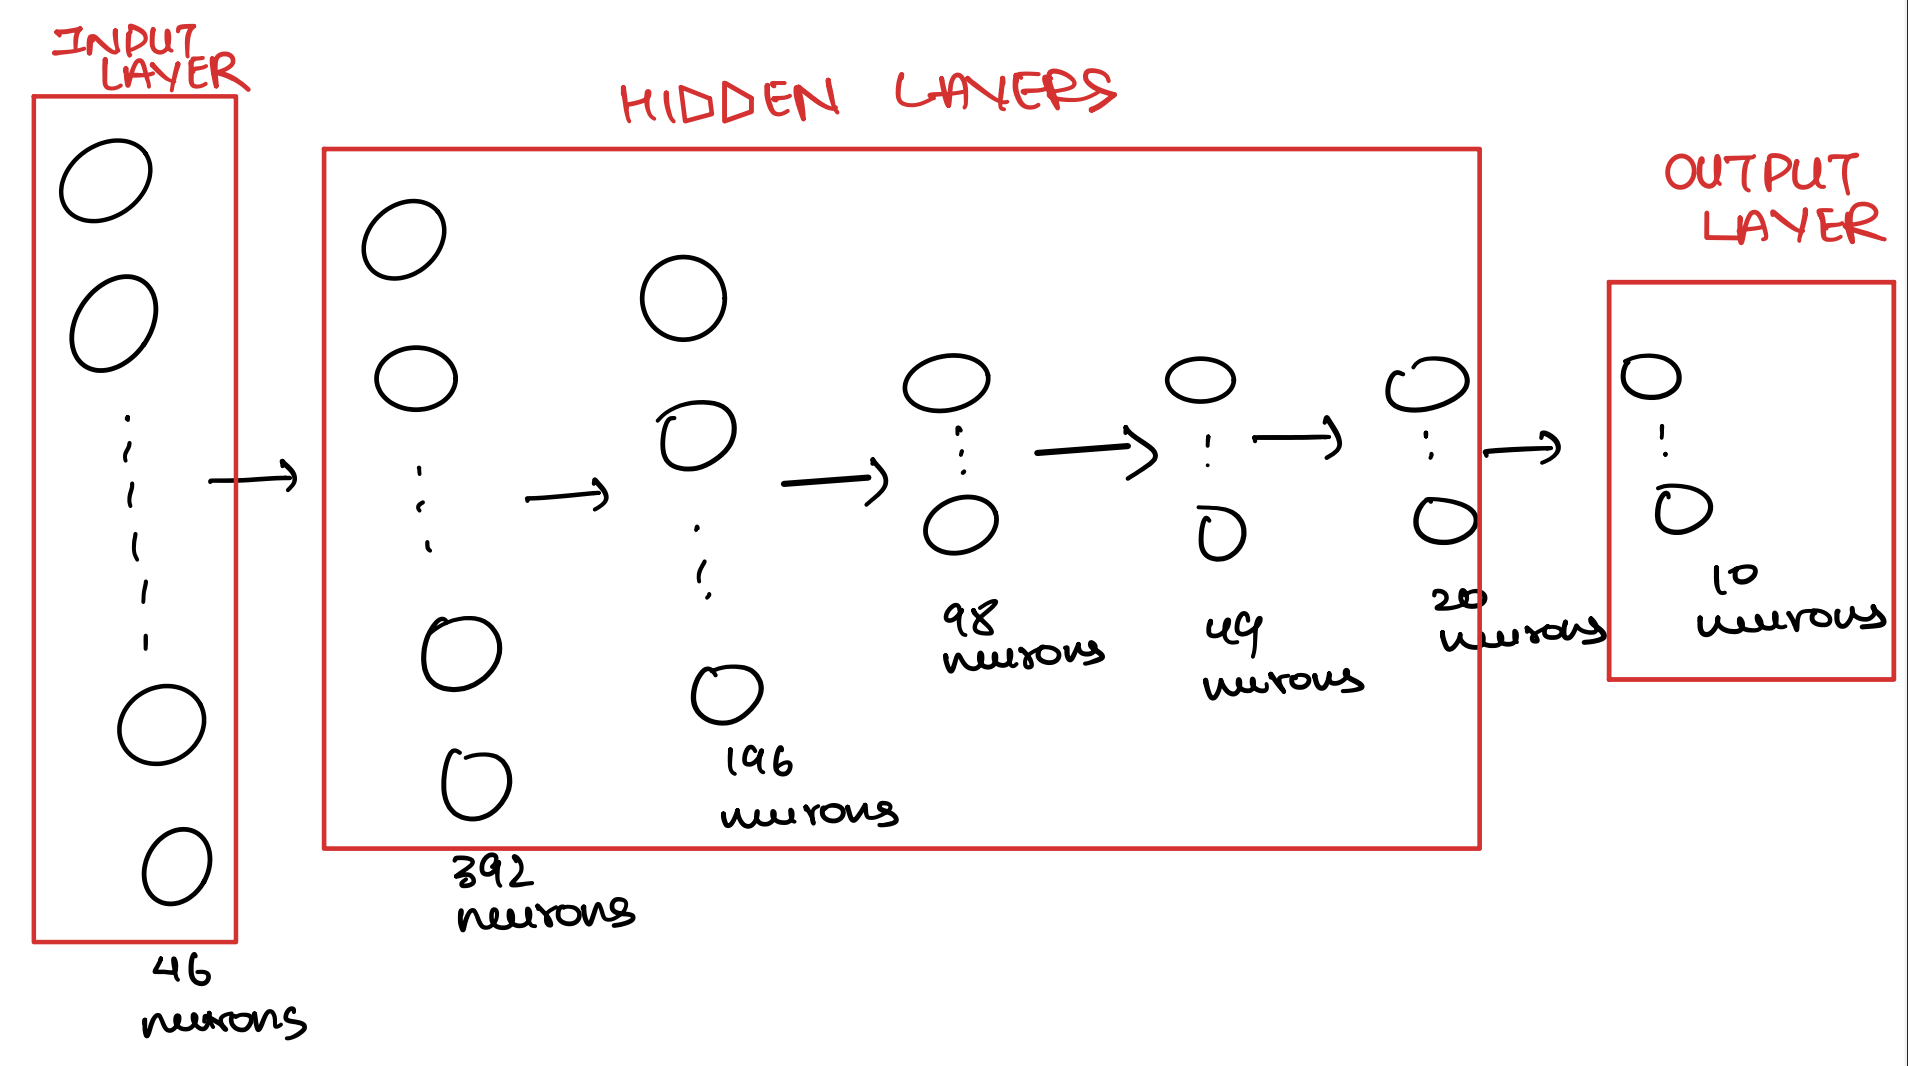

In [ ]:
# defining model architecture
class FFNN_Model(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=46, out_features=392),nn.ReLU(),
            nn.Linear(in_features=392, out_features=196),nn.ReLU(),
            nn.Linear(in_features=196, out_features=98),nn.ReLU(),
            nn.Linear(in_features=98, out_features=49),nn.ReLU(),
            nn.Linear(in_features=49, out_features=20),nn.ReLU(),
            nn.Linear(in_features=20, out_features=10),nn.ReLU()
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

# instantiating the model
ffnn_model = FFNN_Model().to(device)

## Training

In [ ]:
# defining evaluation metric for model => since we have a balanced dataset we will be using accuracy for our model
def accuracy_fn(y_true, y_pred):
    return (torch.eq(y_true, y_pred).sum().item() / len(y_pred)) * 100

In [ ]:
def train_step(model, train_dataloader, optimizer):

    # defining optimizer for the model
    if optimizer == 'SGD':
        optimizer = torch.optim.SGD(params=model.parameters(),lr=0.1)

    # defining loss function for model
    loss_fn = nn.CrossEntropyLoss()

    # housekeeping stuff
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []

    for epoch in tqdm(range(50)):

        print(f"Epoch: {epoch}\n-------")



        '''
        TRAINING
        '''
        train_loss, train_acc = 0, 0
        model.train()
        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X) #Forward pass

            loss = loss_fn(y_pred, y) # Calculate loss (per batch)
            acc = accuracy_fn(y_true=y,y_pred=y_pred.argmax(dim=1))

            train_loss += loss # accumulatively add up the loss per epoch
            train_acc += acc # Go from logits -> pred labels

            optimizer.zero_grad() # Optimizer zero grad
            loss.backward() # Loss backward
            optimizer.step() # Optimizer step

            # Print out how many samples have been seen
            if batch % 400 == 0:
                print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

        # Divide total train loss by length of train dataloader (average loss per batch per epoch)
        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)
        print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

        # housekeeping stuff
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)






        '''
        TESTING
        '''
        test_loss, test_acc = 0, 0
        model.eval()
        with torch.inference_mode():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
                test_pred = model(X) # Forward pass

                loss = loss_fn(test_pred, y)
                acc = accuracy_fn(y_true=y,y_pred=test_pred.argmax(dim=1))

                test_loss += loss
                test_acc += acc

            # Calculations on test metrics need to happen inside torch.inference_mode()
            test_loss /= len(test_dataloader)
            test_acc /= len(test_dataloader)

        print(f"Test loss: {test_loss:.5f}  | Test acc: {test_acc:.2f}%\n")

        # housekeeping stuff
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)




    return train_loss_list, train_acc_list, test_loss_list, test_acc_list

In [ ]:
train_loss_ffnn, train_acc_ffnn, test_loss_ffnn, test_acc_ffnn = train_step(ffnn_model, train_dataloader, 'SGD')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/48928 samples
Looked at 12800/48928 samples
Looked at 25600/48928 samples
Looked at 38400/48928 samples
Train loss: 1.73103 | Train accuracy: 36.07%
Test loss: 2.96241  | Test acc: 9.47%

Epoch: 1
-------
Looked at 0/48928 samples
Looked at 12800/48928 samples
Looked at 25600/48928 samples
Looked at 38400/48928 samples
Train loss: 1.26957 | Train accuracy: 51.63%
Test loss: 3.44629  | Test acc: 12.66%

Epoch: 2
-------
Looked at 0/48928 samples
Looked at 12800/48928 samples
Looked at 25600/48928 samples
Looked at 38400/48928 samples
Train loss: 0.92547 | Train accuracy: 62.62%
Test loss: 3.68568  | Test acc: 11.96%

Epoch: 3
-------
Looked at 0/48928 samples
Looked at 12800/48928 samples
Looked at 25600/48928 samples
Looked at 38400/48928 samples
Train loss: 0.89229 | Train accuracy: 63.79%
Test loss: 3.25317  | Test acc: 12.49%

Epoch: 4
-------
Looked at 0/48928 samples
Looked at 12800/48928 samples
Looked at 25600/48928 samples
Looked at 38400/48928 samp

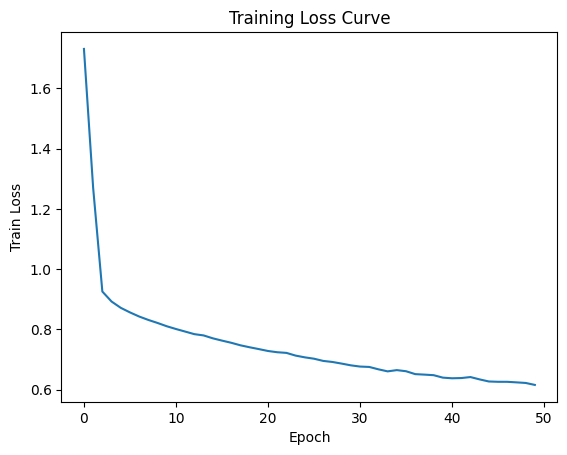

In [ ]:
plt.plot([loss.item() for loss in train_loss_ffnn])
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Training Loss Curve")
plt.show()

## Model Saving

Let's save the model trained parameters so that it can be used in future

In [ ]:
# saving the model
torch.save(ffnn_model.state_dict(), 'ffnn_model.pth')

# <h1> <b> <center> Modelling and Training using Convolution Neural Networks (Resnet) </center> </b> </h1>

Now one of the issues which a FFNN faces is that it does not takes into account the spacial information present in the images since we feed it with the flattened version of images. Hence researchers thought of this kind of network architecture wherein we could incorporate spacial info by creating embedding of a particular pixel in the image using the surrounding pixels. This model is called a convolution network. We have created a [medium article](https://pub.towardsai.net/coding-convolution-neural-networks-cnn-from-scratch-without-pytorch-76e9497fa0c4) highlighting all the important architectures built historically using CNN.

Here we will try to implement a smaller version of the [ResNet Architecture](https://pub.towardsai.net/coding-convolution-neural-networks-cnn-from-scratch-without-pytorch-76e9497fa0c4#f0b6) described in the above blog. Smaller because of lack of computational power!!

## Creating Dataloaders

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

In [ ]:
reduced_train_images_tensor = torch.stack([transform(Image.fromarray(img)) for img in train_images])
reduced_train_labels_tensor = torch.tensor(np.array(reduced_train_labels), dtype=torch.long)
train_dataset = TensorDataset(reduced_train_images_tensor, reduced_train_labels_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
train_features_batch, train_labels_batch = next(iter(train_dataloader))

print(f"Features Batch Size {train_features_batch.shape}")
print(f"Labels Batch Size {train_labels_batch.shape}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of 32")

Features Batch Size torch.Size([32, 1, 28, 28])
Labels Batch Size torch.Size([32])
Length of train dataloader: 1579 batches of 32


In [ ]:
reduced_test_images_tensor = torch.stack([transform(Image.fromarray(img)) for img in test_images])
reduced_test_labels_tensor = torch.tensor(np.array(test_labels), dtype=torch.long)
test_dataset = TensorDataset(reduced_test_images_tensor, reduced_test_labels_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_features_batch, test_labels_batch = next(iter(test_dataloader))

print(f"Features Batch Size {test_features_batch.shape}")
print(f"Labels Batch Size {test_labels_batch.shape}")
print(f"Length of train dataloader: {len(test_dataloader)} batches of 32")

Features Batch Size torch.Size([32, 1, 28, 28])
Labels Batch Size torch.Size([32])
Length of train dataloader: 313 batches of 32


## Creating Model Architecture
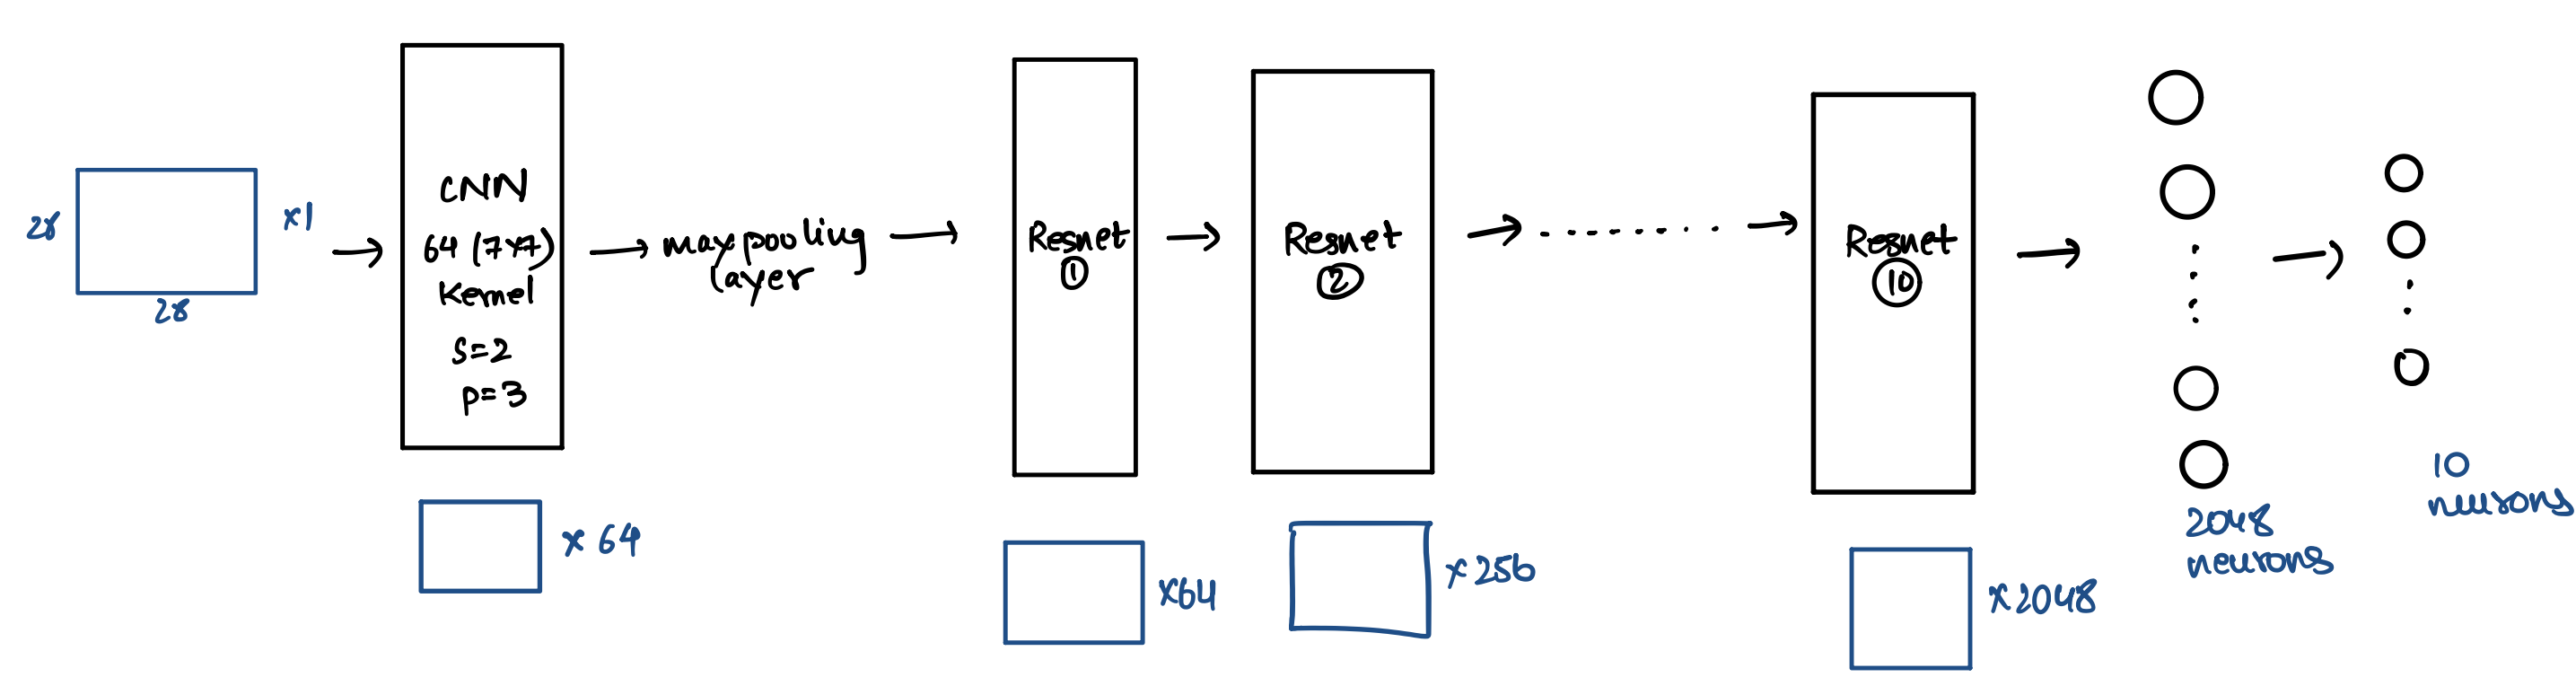

In [ ]:
class ResidualBlock2(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.block = nn.Sequential(
                                      nn.Conv2d( in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False), nn.BatchNorm2d(out_channels), nn.ReLU(),
                                      nn.Conv2d( out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False), nn.BatchNorm2d(out_channels), nn.ReLU(),
                                      nn.Conv2d( out_channels, out_channels * 4, kernel_size=1, stride=1, padding=0, bias=False), nn.BatchNorm2d(out_channels * 4)
                                  )

        self.dim_matching_layer = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels*4, kernel_size = 1, stride = stride, bias = False),
                            nn.BatchNorm2d(out_channels*4)
                            )

    def forward(self, x):

        if self.in_channels != 4 * self.out_channels:
            return self.block(x) + self.dim_matching_layer(x)

        return self.block(x) + x

In [ ]:
class ResNet(nn.Module):

    def __init__(self):
        super(ResNet, self).__init__()

        self.conv1 = nn.Sequential( nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False), nn.BatchNorm2d(64), nn.ReLU() )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.residual_layers = nn.Sequential(
                                        ResidualBlock2(64, 64, 1),
                                        ResidualBlock2(256, 64),
                                        ResidualBlock2(256, 128, 2),
                                        ResidualBlock2(512, 128),
                                        ResidualBlock2(512, 256, 2),
                                        ResidualBlock2(1024, 256),
                                        ResidualBlock2(1024, 256),
                                        ResidualBlock2(1024, 512, 2),
                                        ResidualBlock2(2048, 512),
                                        ResidualBlock2(2048, 512),
                                        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, 10)

    def forward(self, x):

        # feature extraction
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.residual_layers(x)
        x = self.avgpool(x)

        # image flattening
        x = x.reshape(x.shape[0], -1)

        # classification
        x = self.fc(x)

        return x

In [ ]:
# instantiating the model
resnet_model = ResNet().to(device)

## Training

In [ ]:
train_loss_res, train_acc_res, test_loss_ffnn, test_acc_res = train_step(resnet_model, train_dataloader, 'SGD')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/50503 samples
Looked at 12800/50503 samples
Looked at 25600/50503 samples
Looked at 38400/50503 samples
Train loss: 1.30986 | Train accuracy: 71.36%
Test loss: 1.26687  | Test acc: 62.35%

Epoch: 1
-------
Looked at 0/50503 samples
Looked at 12800/50503 samples
Looked at 25600/50503 samples
Looked at 38400/50503 samples
Train loss: 0.52511 | Train accuracy: 81.09%
Test loss: 1.23470  | Test acc: 68.48%

Epoch: 2
-------
Looked at 0/50503 samples
Looked at 12800/50503 samples
Looked at 25600/50503 samples
Looked at 38400/50503 samples
Train loss: 0.43785 | Train accuracy: 84.11%
Test loss: 0.65791  | Test acc: 75.72%

Epoch: 3
-------
Looked at 0/50503 samples
Looked at 12800/50503 samples
Looked at 25600/50503 samples
Looked at 38400/50503 samples
Train loss: 0.39322 | Train accuracy: 85.70%
Test loss: 0.61106  | Test acc: 79.02%

Epoch: 4
-------
Looked at 0/50503 samples
Looked at 12800/50503 samples
Looked at 25600/50503 samples
Looked at 38400/50503 sam

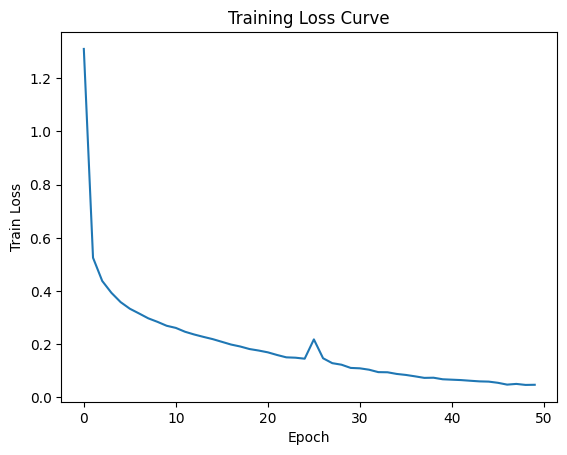

In [ ]:
plt.plot([loss.item() for loss in train_loss_res])
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Training Loss Curve")
plt.show()

## Saving Model

In [ ]:
# saving the model
torch.save(resnet_model.state_dict(), 'resnet_model.pth')

# <h1> <b> <center> Modelling and Training using Vision Transformers </center> </b> </h1>

CNNs were a dominant model for image datasets untill 2017 when the transformer architecture was introduced for NLP use cases in the paper ['Attention is all you need'](https://arxiv.org/abs/1706.03762).

Researchers started applying this model architecture to Computer Vision use-cases too and found amazing results!! This was first introduced in the [Vision Transformers (ViT) Paper](https://arxiv.org/abs/2010.11929).

Here we will try to implement a smaller version of this Vision Transformer paper but before that you can refer this [medium article](https://pub.towardsai.net/transformers-for-images-b14b3ac0dda8) created by us to explain the working of Vision Transformers and this [document](https://drive.google.com/file/d/1PAnq_bn-TU_2qLlkKlJULvZR7brMXKqI/view) to understand how does transformers work in general !!

Note : We will be using the same data-loaders as created above, hence this section does not have a data loader section!!

## Creating Model Architecture
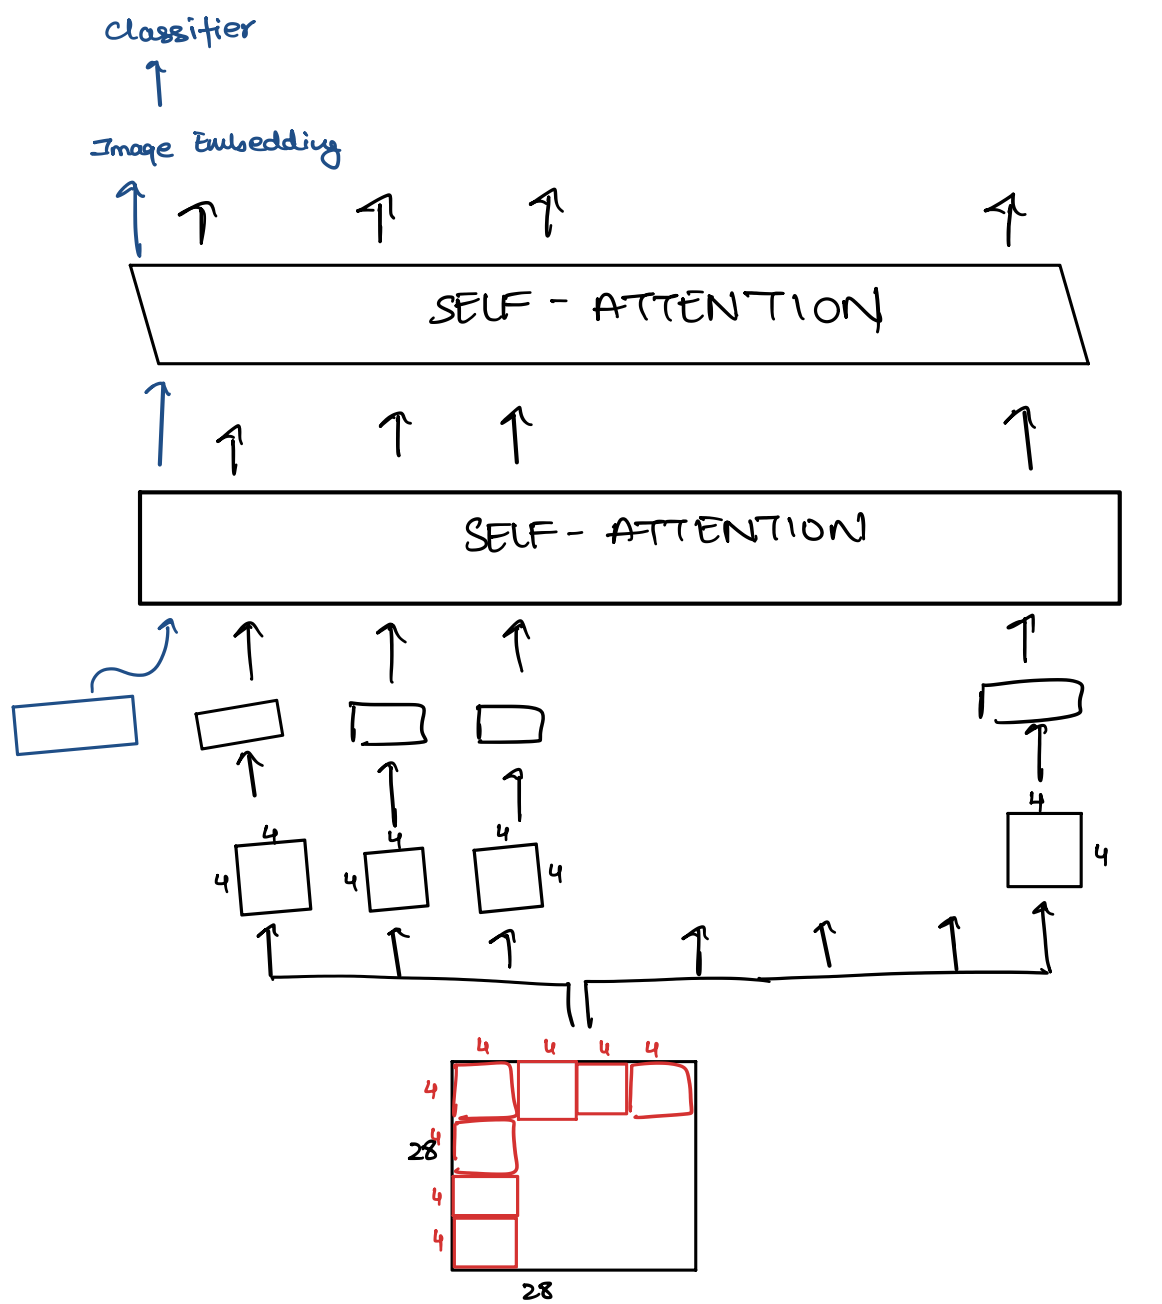

In [ ]:
class ViT(nn.Module):

    def __init__(self, img_size:int=28, in_channels:int=1, patch_size:int=4, embedding_dim:int=768, mlp_size:int=3072, num_classes:int=1000):
        super().__init__()

        self.patch_embedding = nn.Sequential(nn.LayerNorm(1*4*4), nn.Linear(1*4*4, 768), nn.LayerNorm(768))

        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)

        num_patches = (img_size // patch_size) * (img_size // patch_size)
        # num_patches = (img_size * img_size) // patch_size**2
        self.position_embedding = nn.Parameter(data=torch.randn(1, num_patches+1, embedding_dim),requires_grad=True)
        self.embedding_dropout = nn.Dropout(p=0.1)

        self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                                  nhead=2,
                                                                                                  dim_feedforward=mlp_size,
                                                                                                  activation="gelu",
                                                                                                  batch_first=True,
                                                                                                  norm_first=True), # Create a single Transformer Encoder Layer
                                                        num_layers=2) # Stack it N times
        self.classifier = nn.Sequential( nn.LayerNorm(normalized_shape=embedding_dim), nn.Linear(in_features=embedding_dim, out_features=num_classes))


    def forward(self, x):

        # 32, 1, 28, 28 -> 32, 1, 7*4, 7*4 -> 32, 1, 7, 7, 4, 4 -> 32, 7, 7, 4, 4, 1 -> 32, 7*7, 4*4*1 - > 32, num_patches, patch_dim
        x = rearrange(x, 'b c (nh ph) (nw pw) -> b (nh nw) (ph pw c)', ph=4, pw=4)

        # Create patch embedding for all images in the batch
        x = self.patch_embedding(x)

        # Create class embedding and expand it to match the batch size.
        class_token = self.class_embedding.expand(x.shape[0], -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # Concat class embedding with the patch embedding
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding
        x = self.position_embedding + x

        # 17. Run embedding dropout
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [ ]:
vit_model = ViT(num_classes=10).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


## Training the model

In [ ]:
train_loss_vit, train_acc_vit, test_loss_vit, test_acc_vit = train_step(vit_model, train_dataloader, 'SGD')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/50503 samples
Looked at 12800/50503 samples
Looked at 25600/50503 samples
Looked at 38400/50503 samples
Train loss: 1.15208 | Train accuracy: 67.29%
Test loss: 0.79667  | Test acc: 72.06%

Epoch: 1
-------
Looked at 0/50503 samples
Looked at 12800/50503 samples
Looked at 25600/50503 samples
Looked at 38400/50503 samples
Train loss: 0.59801 | Train accuracy: 78.05%
Test loss: 0.78711  | Test acc: 75.29%

Epoch: 2
-------
Looked at 0/50503 samples
Looked at 12800/50503 samples
Looked at 25600/50503 samples
Looked at 38400/50503 samples
Train loss: 0.54118 | Train accuracy: 80.08%
Test loss: 0.50285  | Test acc: 80.90%

Epoch: 3
-------
Looked at 0/50503 samples
Looked at 12800/50503 samples
Looked at 25600/50503 samples
Looked at 38400/50503 samples
Train loss: 0.49790 | Train accuracy: 81.98%
Test loss: 0.57733  | Test acc: 78.80%

Epoch: 4
-------
Looked at 0/50503 samples
Looked at 12800/50503 samples
Looked at 25600/50503 samples
Looked at 38400/50503 sam

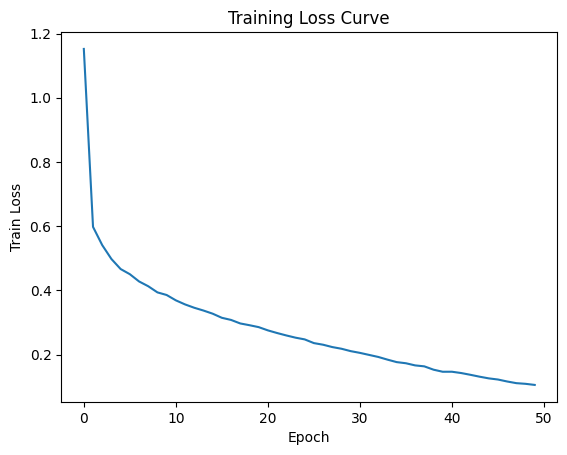

In [ ]:
plt.plot([loss.item() for loss in train_loss_vit])
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Training Loss Curve")
plt.show()

## Saving the Model

In [ ]:
# saving the model => #54.3M params
torch.save(vit_model.state_dict(), 'vit_model.pth')

# <h1> <b> <center>  Result Analysis and Conclusions  </center> </b> </h1>



In [ ]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    count = 0
    input_list = []
    output_list = []
    pred_list = []

    with torch.inference_mode():

        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)

            # Make predictions with the model
            y_pred = model(X)

            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)

            if count % 1000 == 0:
                input_list.append(X)
                output_list.append(y)
                pred_list.append(torch.argmax(torch.softmax(y_pred, dim=1), dim=1))
            count += 1

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc,
            }, input_list, output_list, pred_list

## Evaluating FFNN Model

In [ ]:
# To load the model later:
ffnn_model = FFNN_Model().to(device) # Instantiate the model architecture
ffnn_model.load_state_dict(torch.load('ffnn_model.pth'))

<ipython-input-226-4b2b14bf7204>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ffnn_model.load_state_dict(torch.load('ffnn_model.pth'))


<All keys matched successfully>

In [ ]:
torch.manual_seed(42)
result_json, input, output, pred = eval_model(model=ffnn_model, data_loader=test_dataloader,loss_fn=nn.CrossEntropyLoss(), accuracy_fn=accuracy_fn)

In [ ]:
result_json

{'model_name': 'FFNN_Model',
 'model_loss': 7.396456241607666,
 'model_acc': 13.388578274760384}

In [ ]:
# making predictions for 10 images
for i in range(0,10):

  im = input[0][i].squeeze().to('cpu')
  a = label_dic[output[0][i].squeeze().to('cpu').item()]
  p = label_dic[pred[0][i].squeeze().to('cpu').item()]

  print(f"Truth: {a} | Pred: {p}")

Truth: Ankle boot | Pred: T-shirt/top
Truth: Pullover | Pred: Coat
Truth: Trouser | Pred: T-shirt/top
Truth: Trouser | Pred: Dress
Truth: shirt | Pred: Coat
Truth: Trouser | Pred: Dress
Truth: Coat | Pred: Pullover
Truth: shirt | Pred: shirt
Truth: Sandal | Pred: T-shirt/top
Truth: Sneaker | Pred: Bag


## Evaluating CNN Model

In [ ]:
# To load the model later:
resnet_model = ResNet().to(device) # Instantiate the model architecture
resnet_model.load_state_dict(torch.load('resnet_model.pth'))

<ipython-input-139-8e7aa4f456c1>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_model.load_state_dict(torch.load('resnet_model.pth'))


<All keys matched successfully>

In [ ]:
torch.manual_seed(42)
result_json, input, output, pred = eval_model(model=resnet_model, data_loader=test_dataloader,loss_fn=nn.CrossEntropyLoss(), accuracy_fn=accuracy_fn)

In [ ]:
result_json

{'model_name': 'ResNet',
 'model_loss': 0.48717042803764343,
 'model_acc': 89.82627795527156}

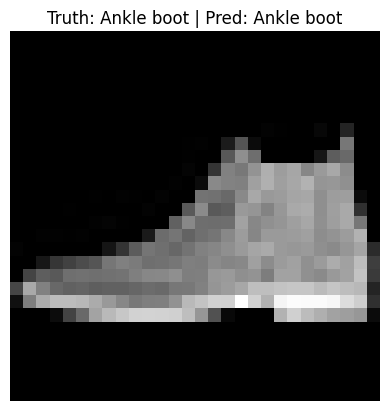

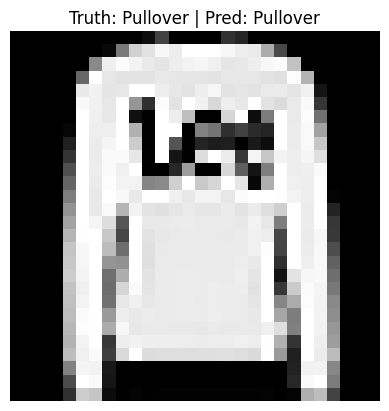

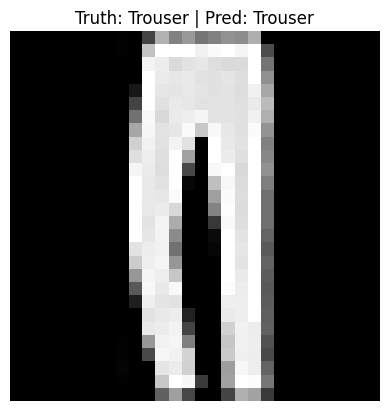

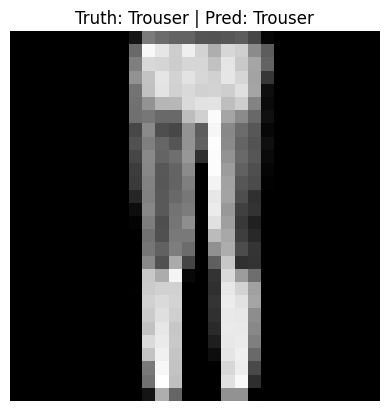

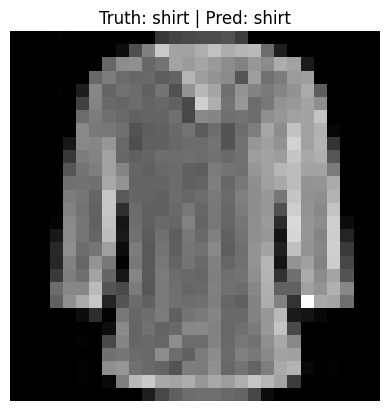

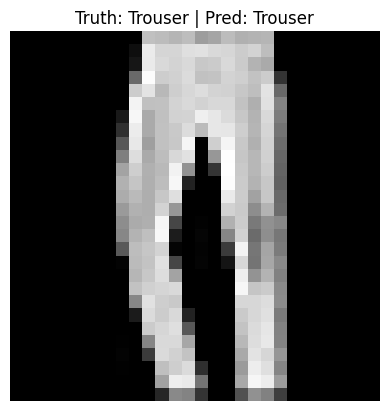

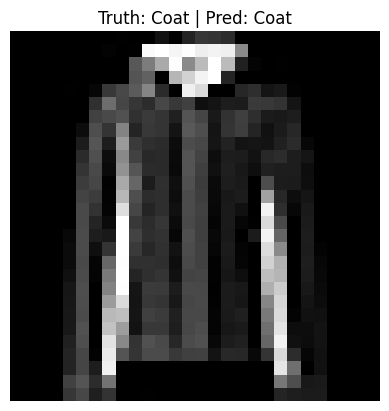

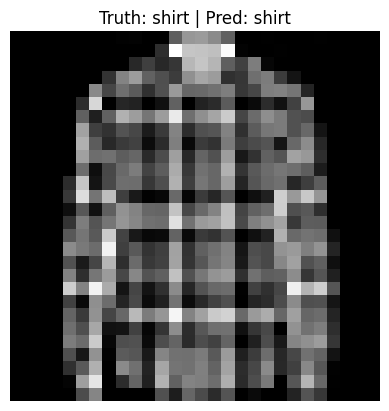

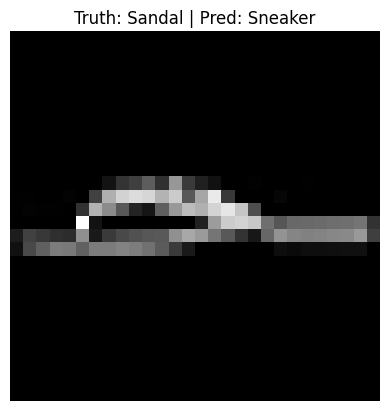

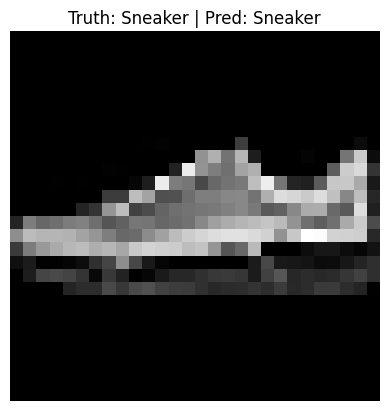

In [ ]:
# making predictions for 10 images
for i in range(0,10):

  im = input[0][i].squeeze().to('cpu')
  a = label_dic[output[0][i].squeeze().to('cpu').item()]
  p = label_dic[pred[0][i].squeeze().to('cpu').item()]

  plt.figure()
  plt.imshow(im, cmap="gray")
  plt.title(f"Truth: {a} | Pred: {p}")
  plt.axis(False);

## Evaluating Vision Transfomer Model

In [ ]:
# To load the model later:
vit_model = ViT().to(device) # Instantiate the model architecture
vit_model.load_state_dict(torch.load('vit_model.pth'))

In [ ]:
torch.manual_seed(42)
result_json, input, output, pred = eval_model(model=vit_model, data_loader=test_dataloader,loss_fn=nn.CrossEntropyLoss(), accuracy_fn=accuracy_fn)

In [ ]:
result_json

{'model_name': 'ViT',
 'model_loss': 0.5384005904197693,
 'model_acc': 88.26876996805112}

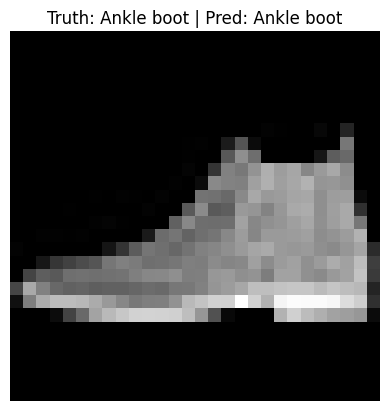

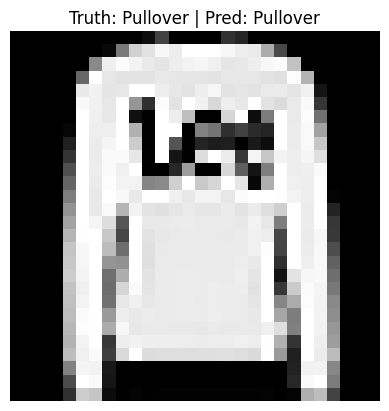

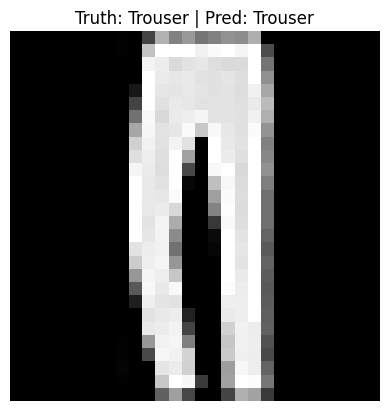

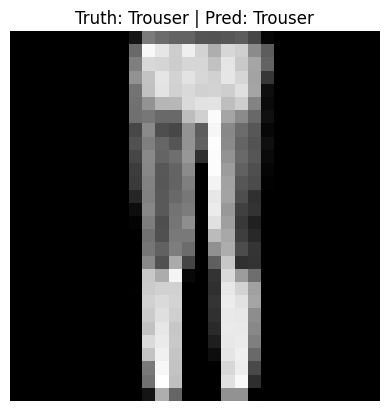

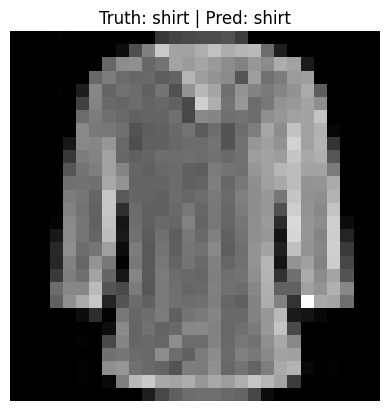

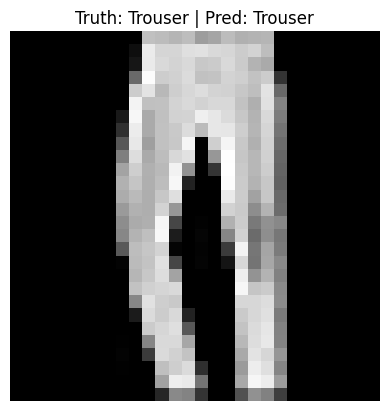

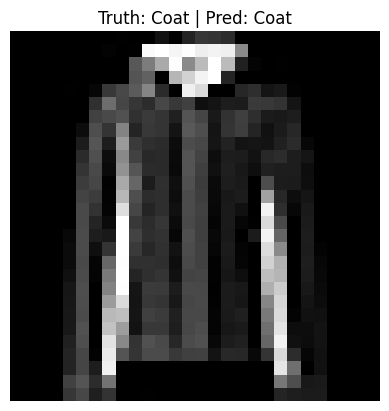

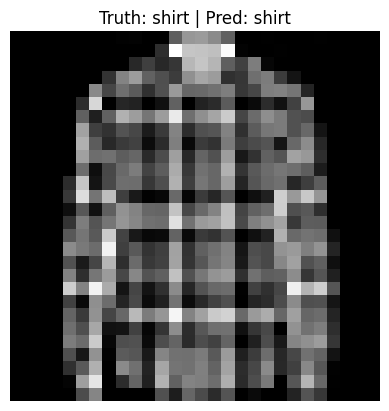

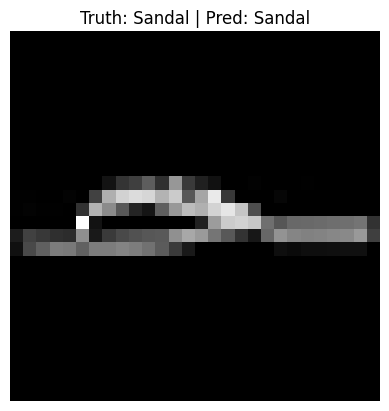

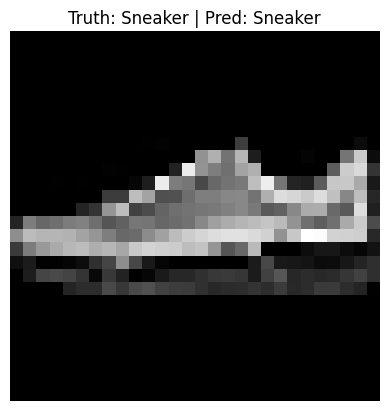

In [ ]:
# making predictions for 10 images
for i in range(0,10):

  im = input[0][i].squeeze().to('cpu')
  a = label_dic[output[0][i].squeeze().to('cpu').item()]
  p = label_dic[pred[0][i].squeeze().to('cpu').item()]

  plt.figure()
  plt.imshow(im, cmap="gray")
  plt.title(f"Truth: {a} | Pred: {p}")
  plt.axis(False);

# Conclusion

- The Feed Forward Neural Network (FFNN) significantly underperformed, with a low accuracy of 13.39% and a high loss of 7.396, indicating its unsuitability for image classification without advanced feature extraction techniques.

- The ResNet model achieved the highest accuracy (89.83%) and the lowest loss (0.487), demonstrating its robustness and effectiveness for image classification tasks.

- The Vision Transformer (ViT) also performed well, with an accuracy of 88.27% and a loss of 0.538, highlighting its potential for handling complex datasets despite being slightly less efficient than ResNet.

- ViTs demonstrated superior performance on complex datasets, although at higher computational costs.

- Data augmentation significantly improved the generalization of all models.
